## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam\*. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod xobliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

\* - Czytając, zwróć uwagę na podział na sekcje _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import *

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

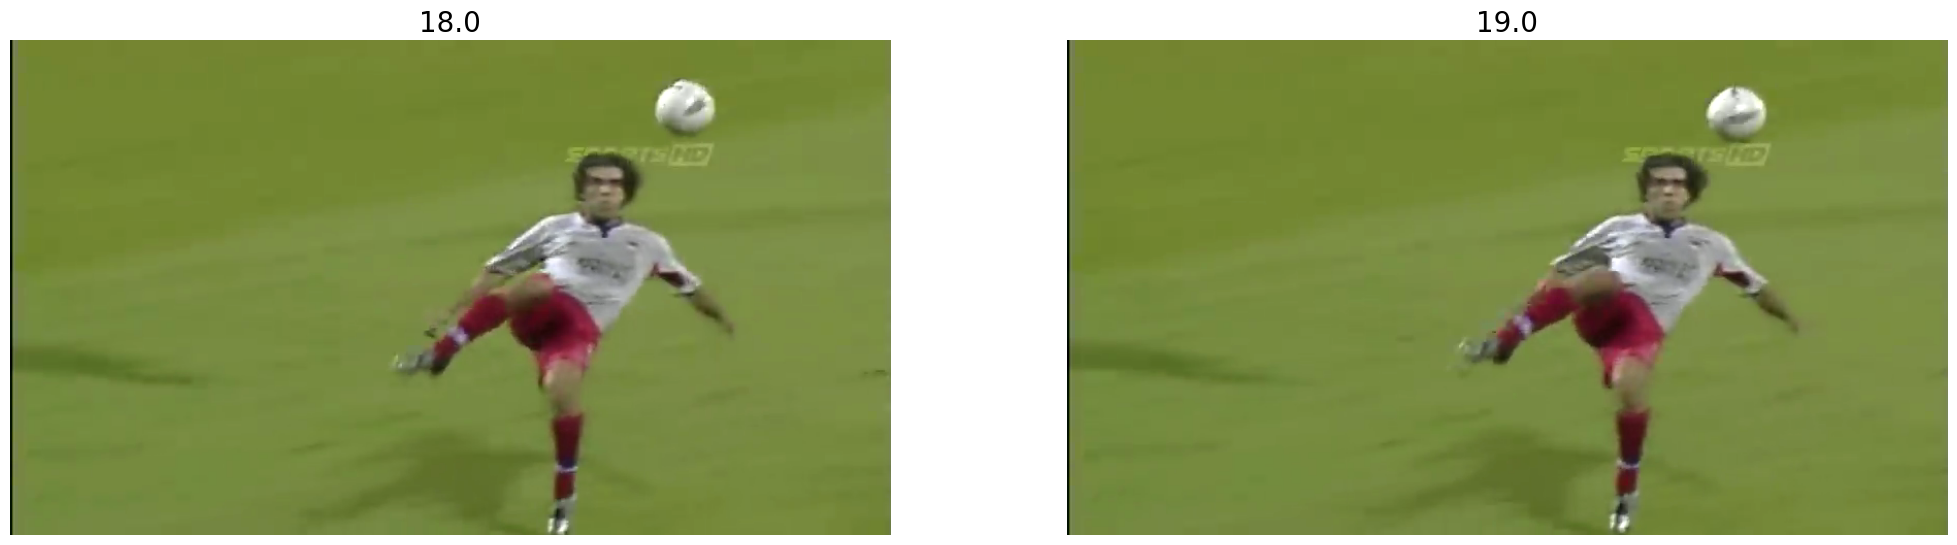

In [54]:
kick_path = '../Lab 8 - dane/kick.mp4'

vid = cv2.VideoCapture(kick_path)

desired_time = 0.7  # Sekundy
desired_frame = int(desired_time * 25)  # Przelicz na liczbę klatek (przy założeniu 25 fps)

for _ in range(desired_frame):
    ret, frame = vid.read()

ret, frame1 = vid.read()
frame1_id= vid.get(cv2.CAP_PROP_POS_FRAMES)

ret, frame2 = vid.read()
frame2_id = vid.get(cv2.CAP_PROP_POS_FRAMES)

display_images([frame1, frame2], [frame1_id, frame2_id])

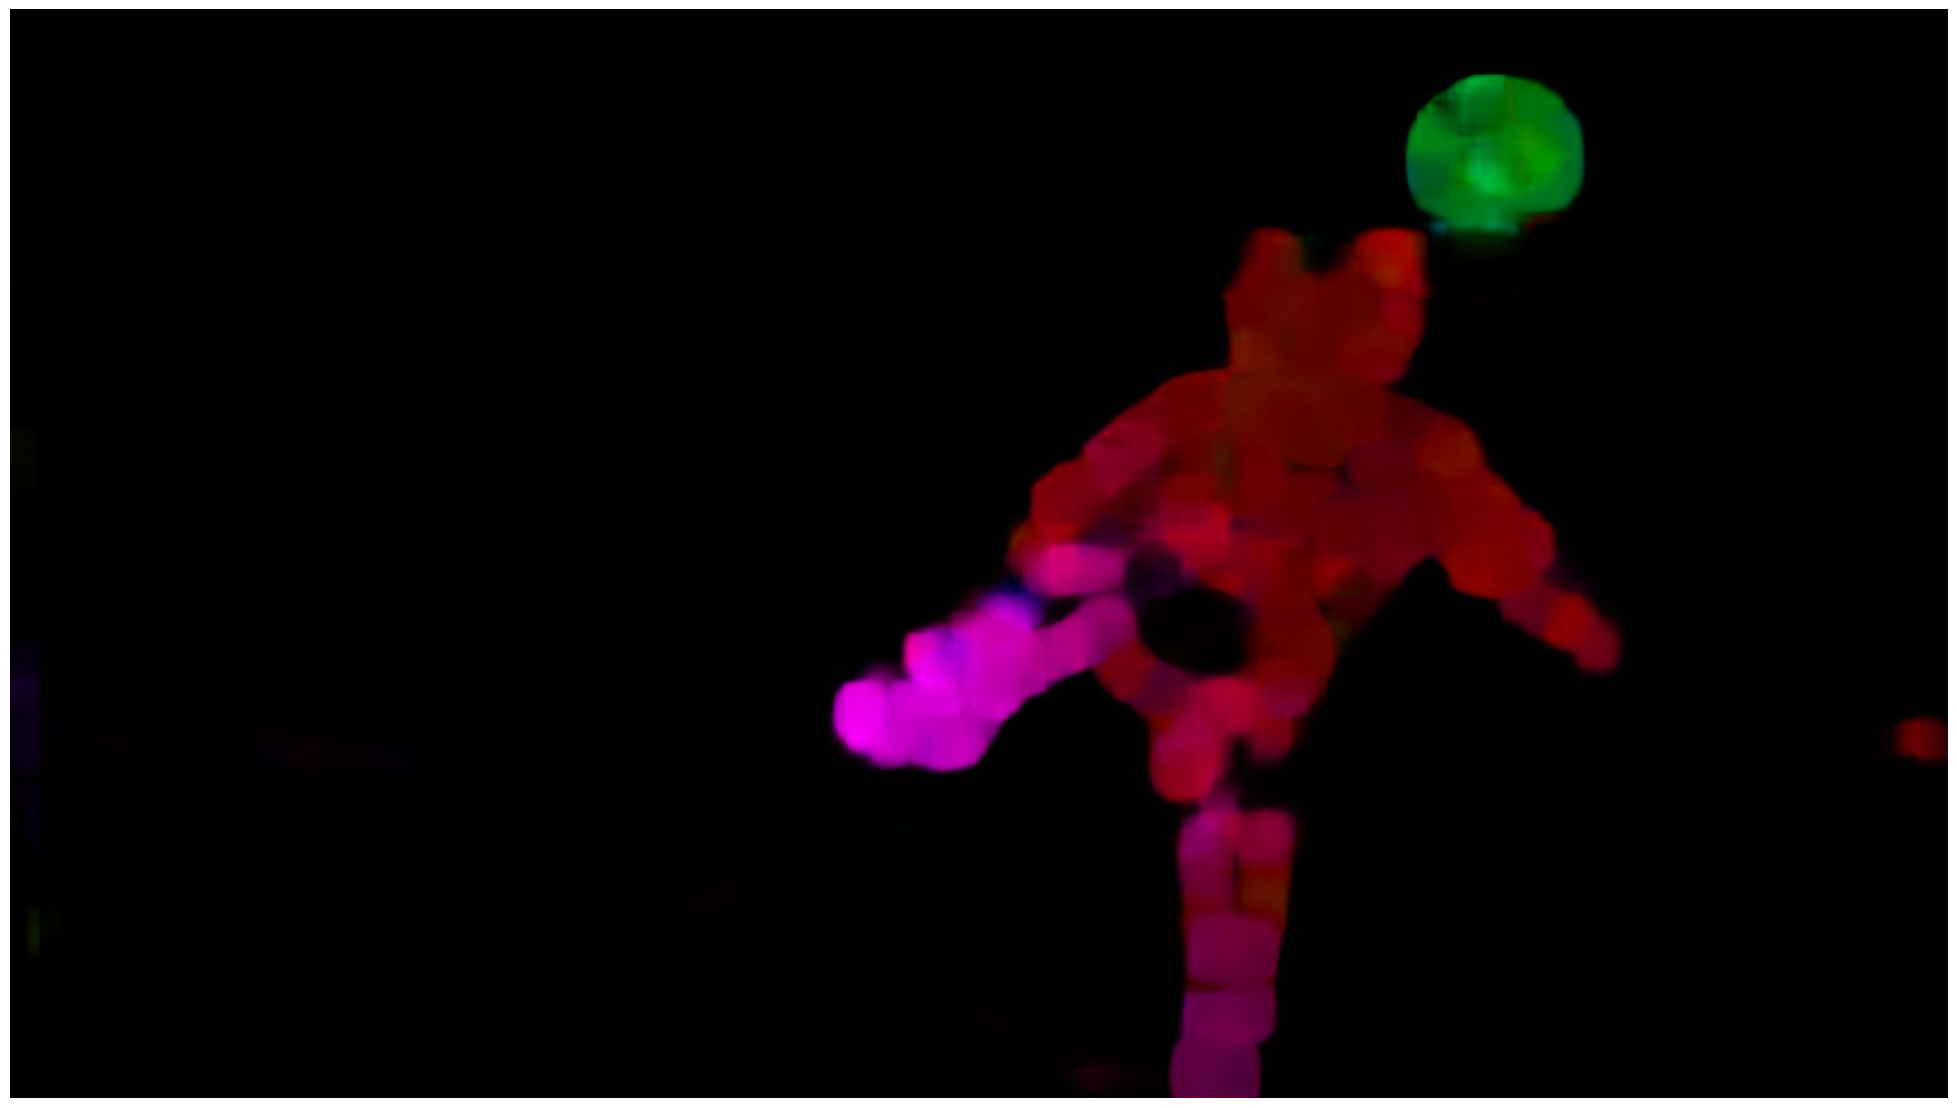

In [55]:
flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY),
                                    cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY),
                                    None, 0.5, 3, 15, 3, 5, 1.2, 0)

mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) # cartesian to polar coordinates
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # magnitude to value
rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

display_images(rgb_flow)

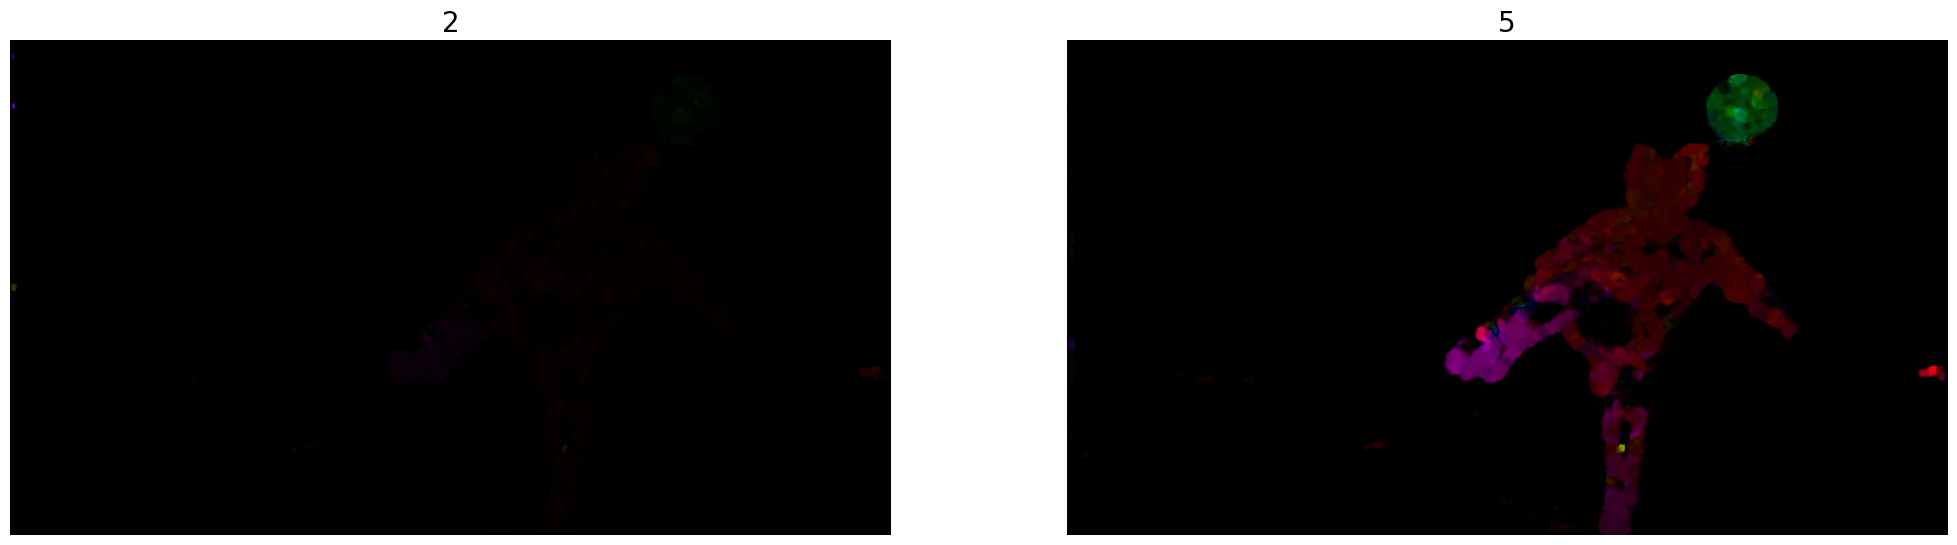

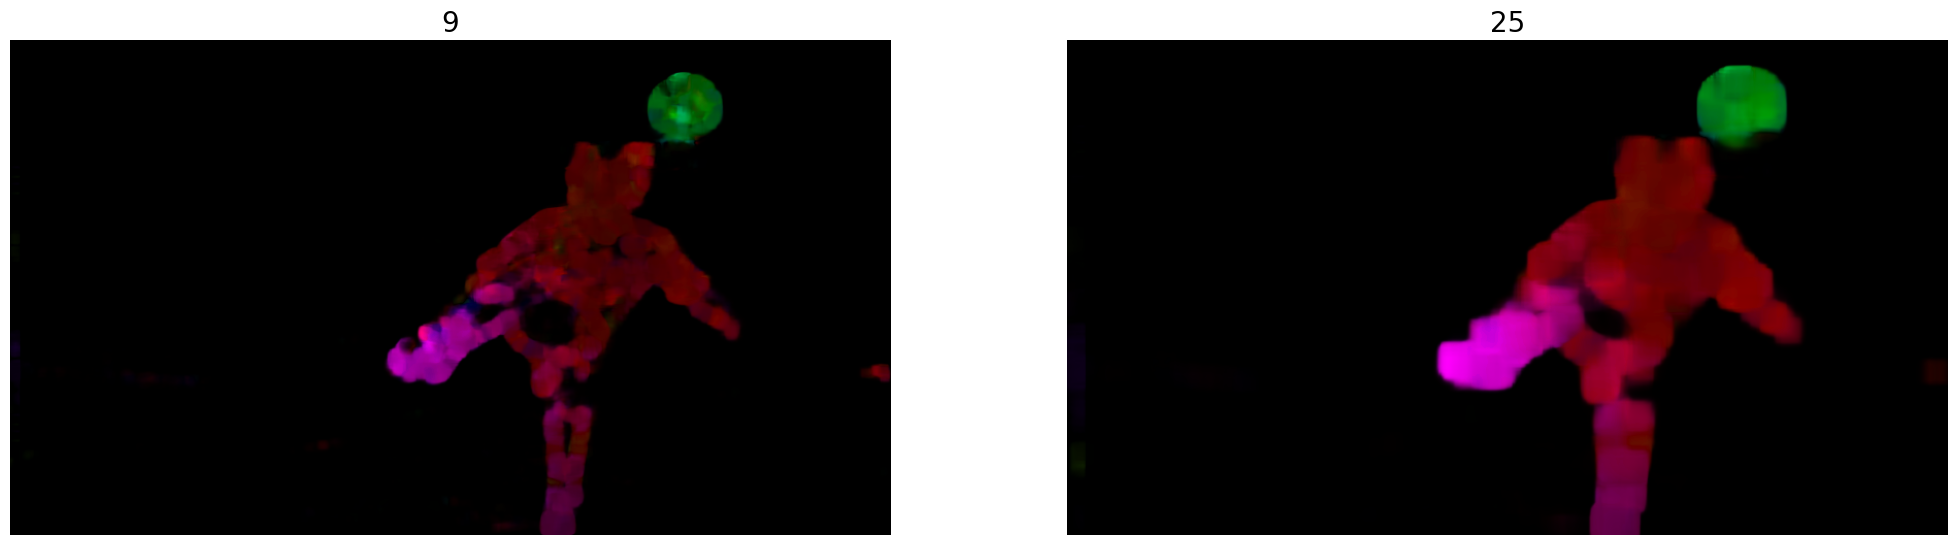

In [56]:
winsizes = [2, 5, 9, 25]
results = []
for idx, winsize in enumerate(winsizes):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY),
                                        cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY),
                                        None, 0.5, 3, winsize, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) # cartesian to polar coordinates
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # magnitude to value
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    results.append(rgb_flow)
    if len(results) % 2 == 0:
        display_images(results[-2:], winsizes[idx-1:idx+1])

rozmiar okna detekcji wpływa na czułość na ruch, a czarne plamu świadczą o braku ruchu ze względu na zbyt mały rozmiar okna w który nie występuje przepływ optyczny

[h264 @ 0x103f29260] mmco: unref short failure
[h264 @ 0x103f29260] mmco: unref short failure


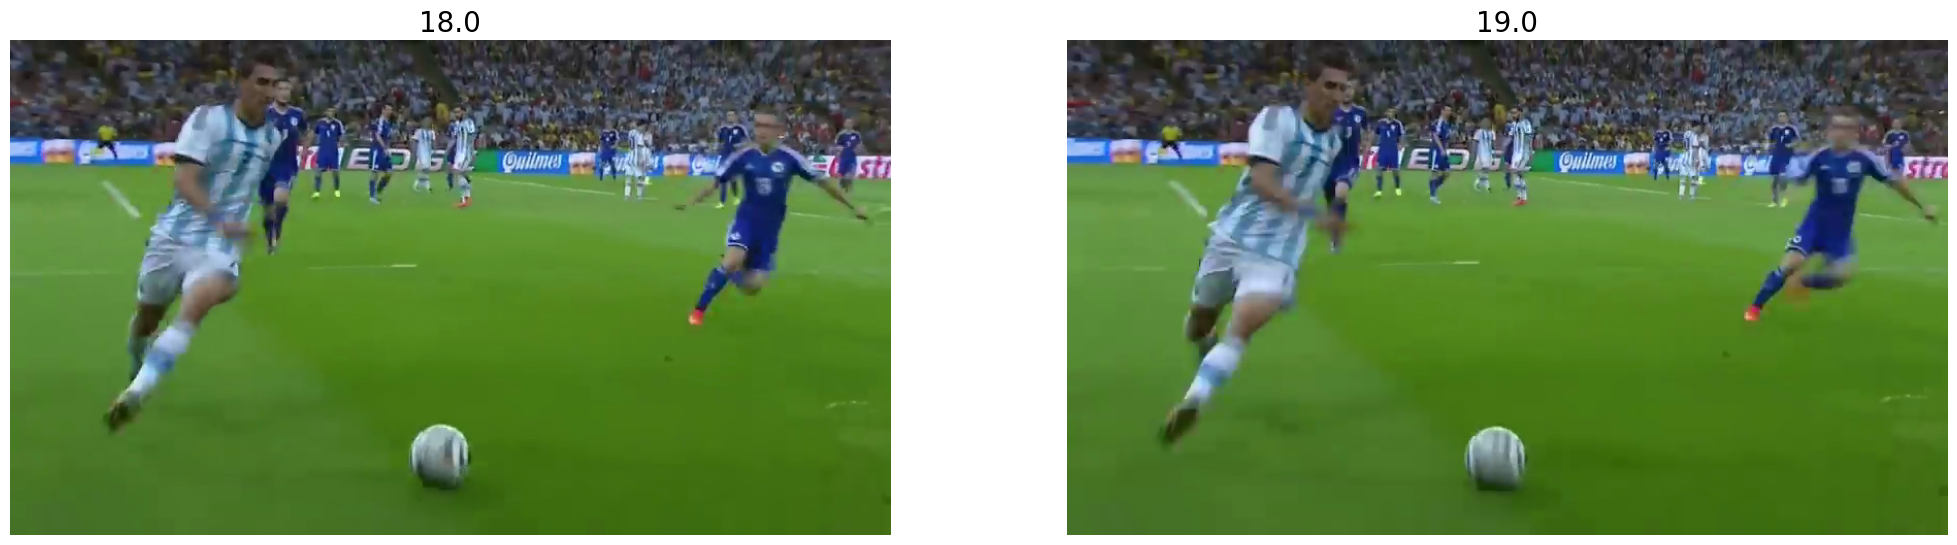

In [57]:
back_path = '../Lab 8 - dane/back.mp4'

vid2 = cv2.VideoCapture(back_path)

desired_time = 0.7# Sekundy
desired_frame = int(desired_time * 25)  # Przelicz na liczbę klatek (przy założeniu 25 fps)

for _ in range(desired_frame):
    ret, frame = vid2.read()
    
ret, frame1 = vid2.read()
frame1_id= vid2.get(cv2.CAP_PROP_POS_FRAMES)

ret, frame2 = vid2.read()
frame2_id = vid2.get(cv2.CAP_PROP_POS_FRAMES)

display_images([frame1, frame2], [frame1_id, frame2_id])

<class 'numpy.ndarray'>


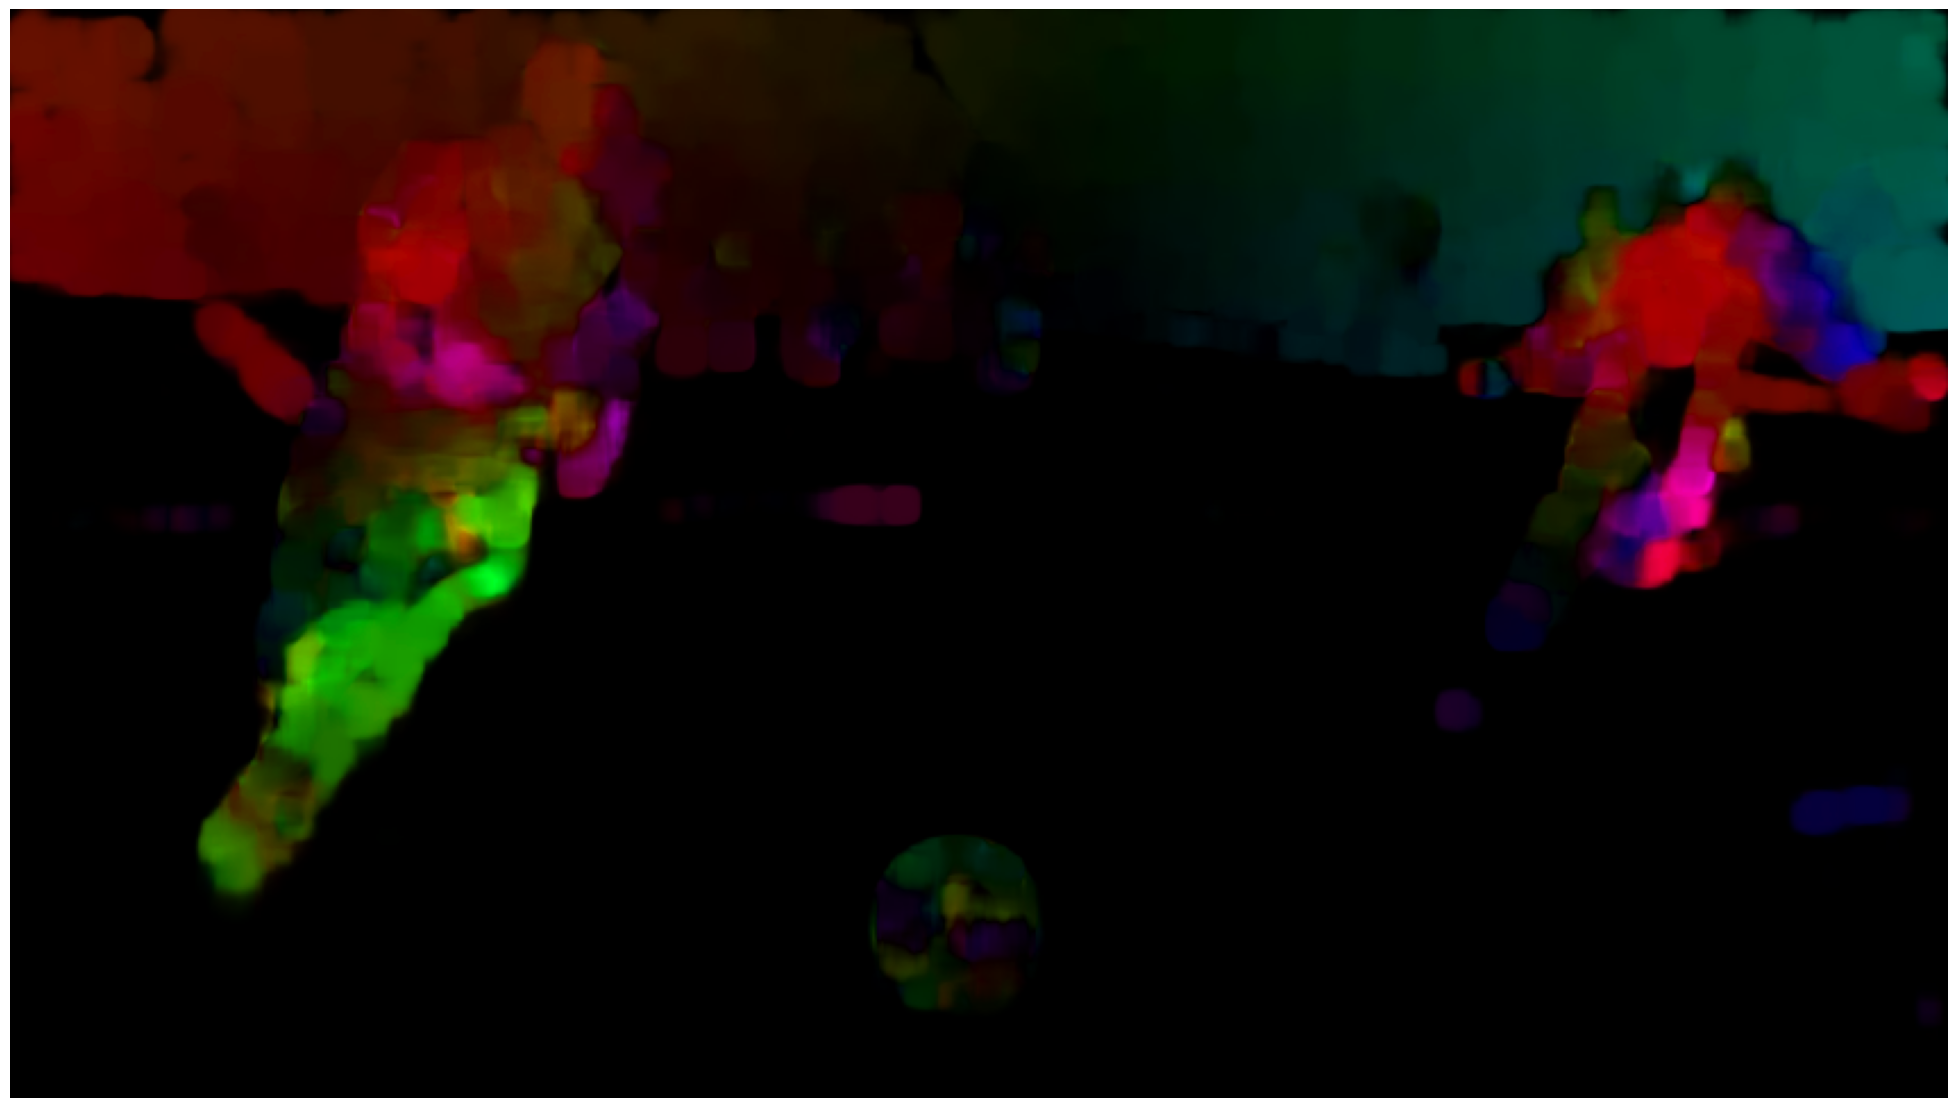

In [58]:
flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY),
                                    cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY),
                                    None, 0.5, 3, 10, 3, 5, 1.2, 0)

mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) # cartesian to polar coordinates
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # magnitude to value
rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
print(type(rgb_flow))
display_images(rgb_flow)

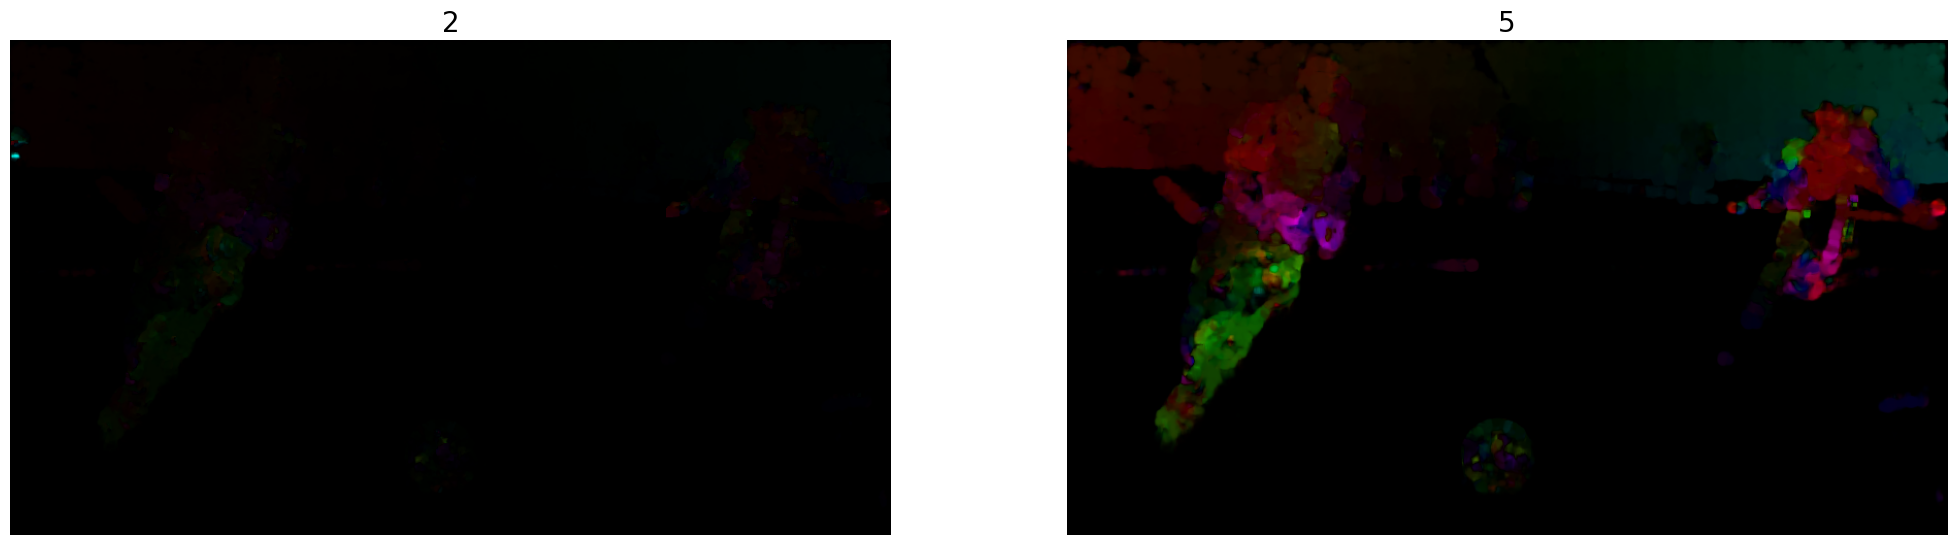

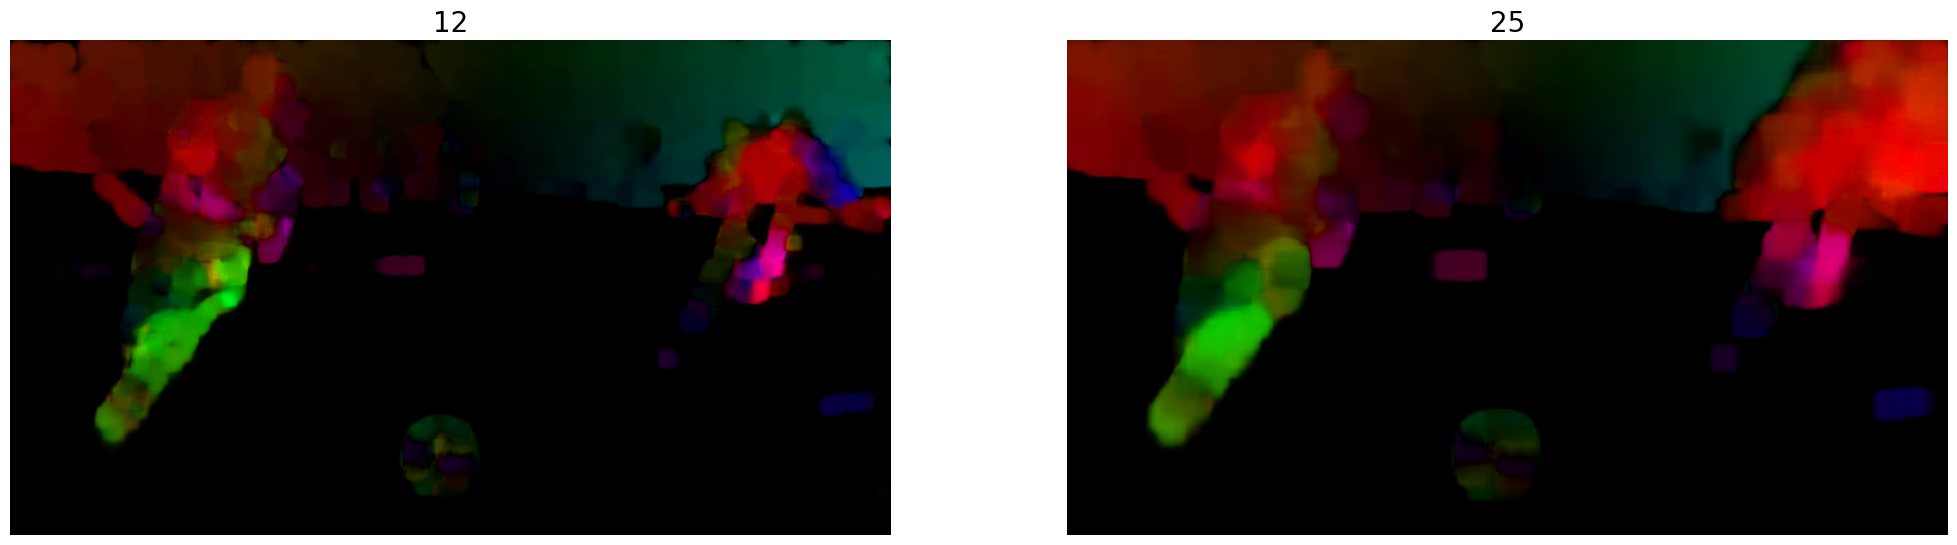

In [59]:
winsizes = [2, 5, 12, 25]
results = []
for idx, winsize in enumerate(winsizes):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY),
                                        cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY),
                                        None, 0.5, 3, winsize, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) # cartesian to polar coordinates
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # magnitude to value
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    results.append(rgb_flow)
    if len(results) % 2 == 0:
        display_images(results[-2:], winsizes[idx-1:idx+1])

Komentarz 1:
wraz ze wzrostem winsze rośnie czułość na ruch

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

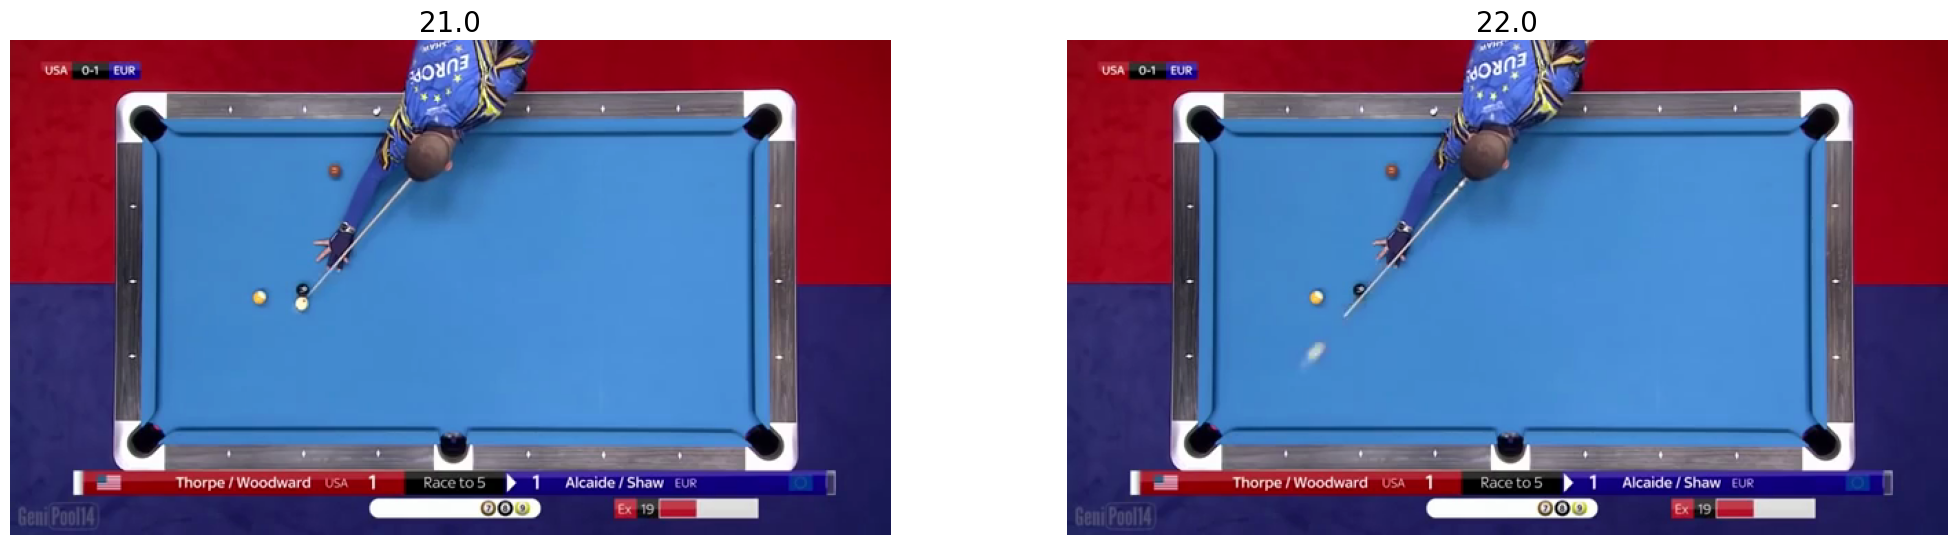

In [60]:
shot_path = '../Lab 8 - dane/shot.mp4'

vid3 = cv2.VideoCapture(shot_path)

desired_frame = 20

for _ in range(desired_frame):
    ret, frame = vid3.read()
    
ret, frame1 = vid3.read()
frame1_id= vid3.get(cv2.CAP_PROP_POS_FRAMES)

ret, frame2 = vid3.read()
frame2_id = vid3.get(cv2.CAP_PROP_POS_FRAMES)

display_images([frame1, frame2], [frame1_id, frame2_id])

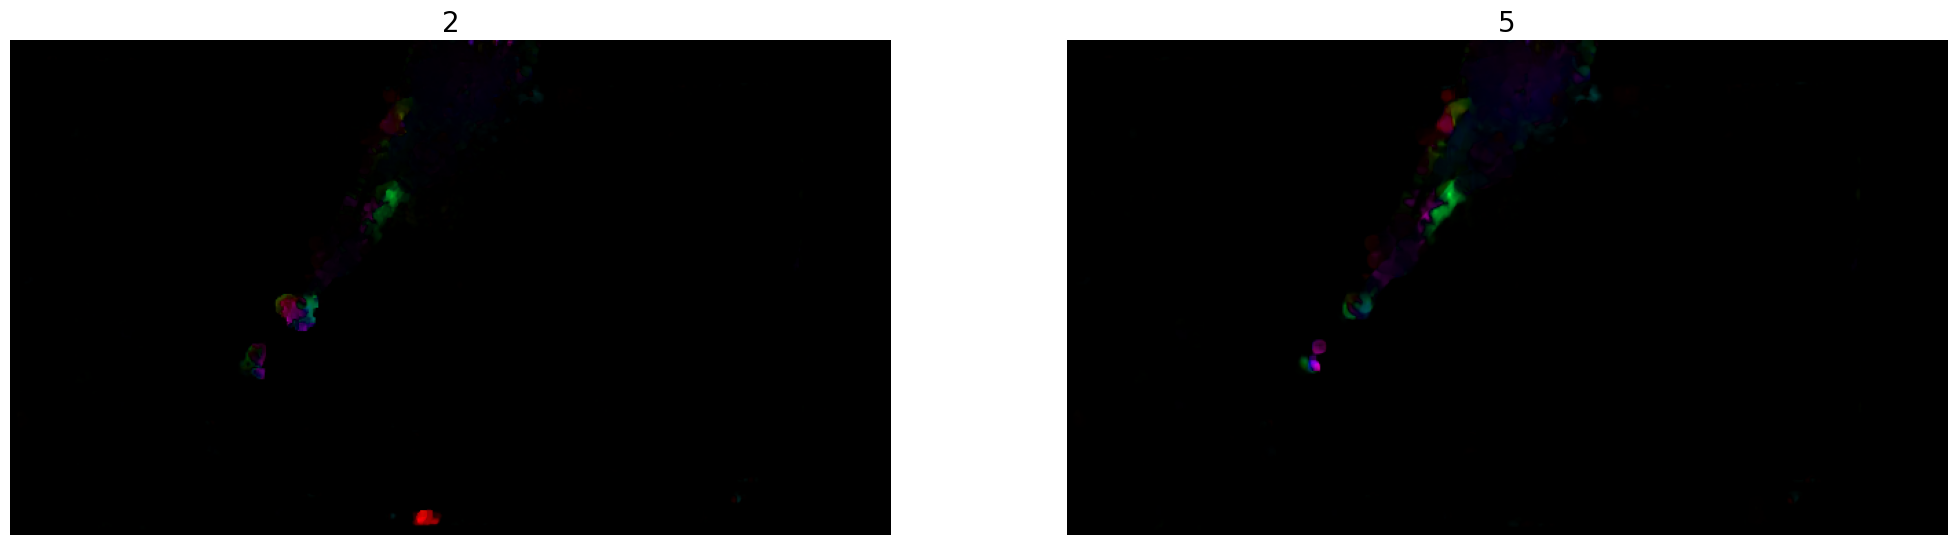

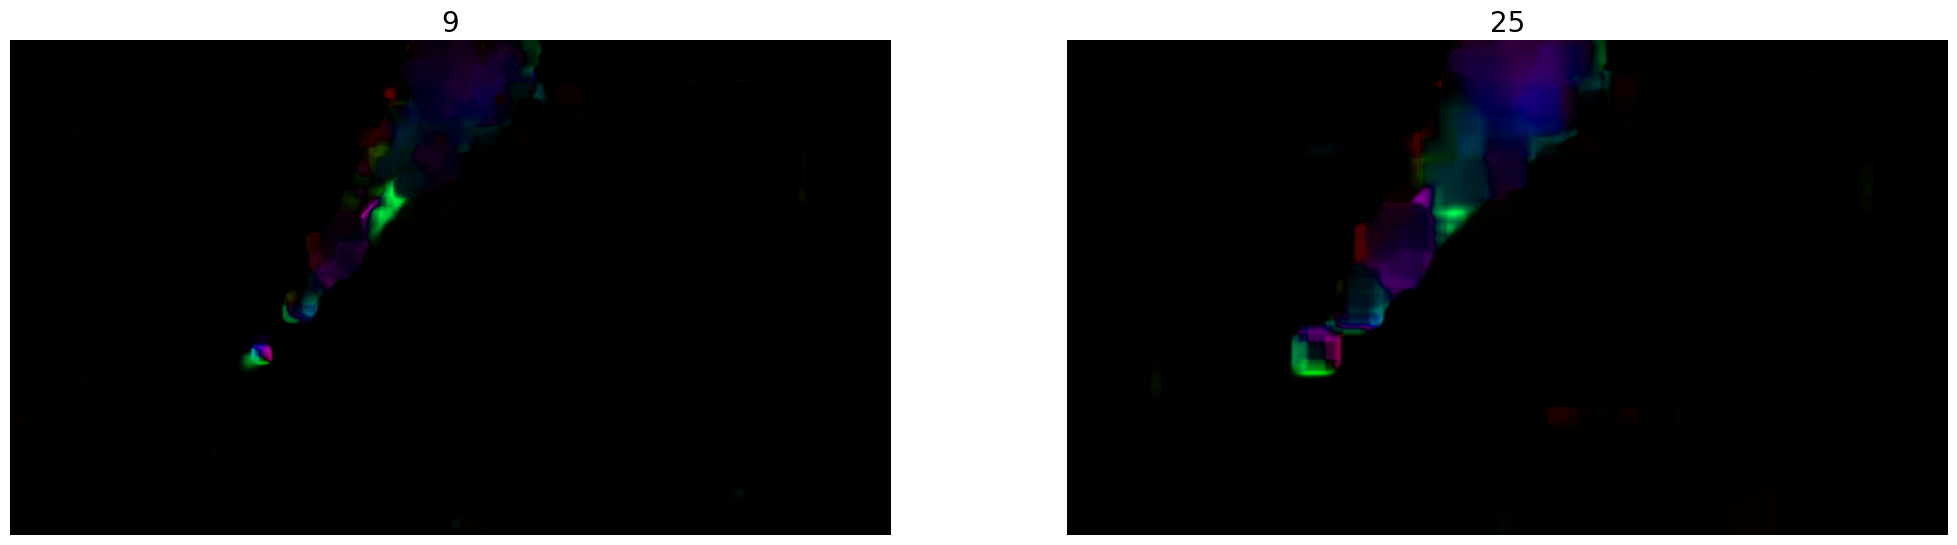

In [61]:
winsizes = [2, 5, 9, 25]
results = []
for idx, winsize in enumerate(winsizes):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY),
                                        cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY),
                                        None, 0.5, 3, winsize, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) # cartesian to polar coordinates
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # magnitude to value
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    results.append(rgb_flow)
    if len(results) % 2 == 0:
        display_images(results[-2:], winsizes[idx-1:idx+1])

Komentarz 2:
przy strzale gracz się porusza a nasza metoda "globalna" wykrywa ruch niechciany (przy założeniu że interesuje nas tor bili)
Ruch bili jest zbyt szybki dla naszej metody, która zakłada niewielkie przesunięcia obiektów, ze wzgledu na zbyt mały fps ruch bili jest wykrywany w 3 różnych kierunkach
...

### Zadanie dodatkowe

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).